# Описание модели

Агентная модель многоотраслевой экономики. Единственные агенты в этой модели - __фирмы__. То, с помощью чего они между собой взаимодействуют, называется __рынком__.

## Рынок

Характеризуется двумя матрицами - матрицами объёмов ($V$) и цен ($P$). Также на рынках хранится выручка фирм, каждая фирма получает эту выручку к началу своего хода. 
Для экономики с $n$ агентами и $k$ отраслями, эти матрицы будут выглядеть так:

$$V = \begin{pmatrix} 
V_{0, 0} \cdots V_{0, j} \cdots V_{0, k} \\
\vdots  \quad  \ddots \quad \quad  \vdots \\
V_{i, 0} \cdots  V_{i, j} \cdots V_{i, k} \\
\vdots \quad  \quad  \ddots \quad \vdots \\
V_{n, 0} \cdots V_{n, j} \cdots V_{n, k} \\
\end{pmatrix}, \quad P = \begin{pmatrix} 
P_{0, 0} \cdots P_{0, j} \cdots P_{0, k} \\
\vdots  \quad  \ddots \quad \quad  \vdots \\
P_{i, 0} \cdots  P_{i, j} \cdots P_{i, k} \\
\vdots \quad  \quad  \ddots \quad \vdots \\
P_{n, 0} \cdots P_{n, j} \cdots P_{n, k} \\
\end{pmatrix} $$

$V_{i, j}$ - объёмы на рынке у фирмы $i$ на товар $j$. $P_{i, j}$ - цены на рынке у фирмы $i$ на товар $j$


## Фирма

### Все фирмы 

Фирма характеризуется:

- Производственной функцией: $f_{prod}(\vec{x}_{in}) = \vec{x}_{out}$

### Фирма с основным капиталом

- Основным капиталом: $\mathcal{K}$, задающий максимальные производственные объёмы. Основной капитал $K_{t}$, приобретенный в некотором периоде, существует на протяжении некоторого количества ходов $d$. Таким образом, объём основного капитала фирмы $i$ на момент времени {t}: $\mathcal{K}_{i} = \sum_{\tau=t-d}^t \mathcal{K}_{i, \tau}$


- Производственной функцией: $f_{prod}(\vec{x}_{in}, \mathcal{K}) = \min\{f_{prod}(\vec{x}_{in}), \mathcal{K}\} = \vec{x}_{out}$

- Инвестиционной функцией: $f_{invest}(\vec{x}_{in}) = \mathcal{K}_{new}$


## Гиперпараметры среды

- Начальные резервы фирм

- Начальные цены

- Начальные финансовые ресурсы фирм

- Время существования основного капитала

# Описание экспериментов

Для того, чтобы проверить адекватность фреймворка, было принято решение для начала посмотреть, как будет идти обучение агентов, если игра будет не с нулевой суммой. 
Оказывается, что если сделать всё аккуратно, подобрать наилучший алгоритм для данной задачи (Multi-Agent Proximal Policy Optimization) и соблюсти кучу нюансов (https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/), то агенты добросовестно будут максимизировать награду. Другие алгоритмы обучения с подкреплением (off-policy) (Multi-Agent Soft Actor Critic) показали худшие результаты, чем MAPPO (on-policy), с которым вышло и быстрее, и стабильнее, и награды выше.  


## 0. Подготовка


## 1. Обучение

## 2. Симуляция


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from environment_batched import BatchedLeontief, BatchedEnvironment
from models.policy import BetaPolicyNetwork
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, TrainerPPO
from utils.plotting import plot_actions, plot_environment, plot_volumes

In [3]:
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
# Гиперпараметры рынка
market_kwargs = dict(
    start_volumes=10,      # У всех фирм в резервах изначально 4 товара А и 10 товара Б
    base_price=50,         # Изначальные цены на рынке - 50 
    start_gains=500,       # Изначальные финансовые ресурсы у каждой фирмы - 500
    deprecation_steps=2,   # За сколько ходов износится основной капитал
    min_price=1,           # Минимальная возможная цена на рынке
    max_price=100          # Максимальная возможная цена на рынке
)

In [7]:
# Производственные функции
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),  # 1 товара А + 0 товара Б => 2 товара Б 
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),  # 0 товара А + 1 товар  Б => 2 товара А.
]

invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(2), device=device),
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(2), device=device),
]

In [5]:
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork,
                         prod_functions,
                         invest_functions=None,
                         target='production',
                         production_reg=0,
                         device=device,
                         batch_size=512)
trainer = TrainerPPO(env,
                     learning_rates=(3e-3, 3e-4),
                     batch_size=512,
                     entropy_reg=0.01,
                     buffer_size=8192 * 64,
                     device=device,
                     entropy_gamma=0.999,
                     lr_gamma=0.991,
                     common_optimizer=True
                     )

# Первый эксперимент

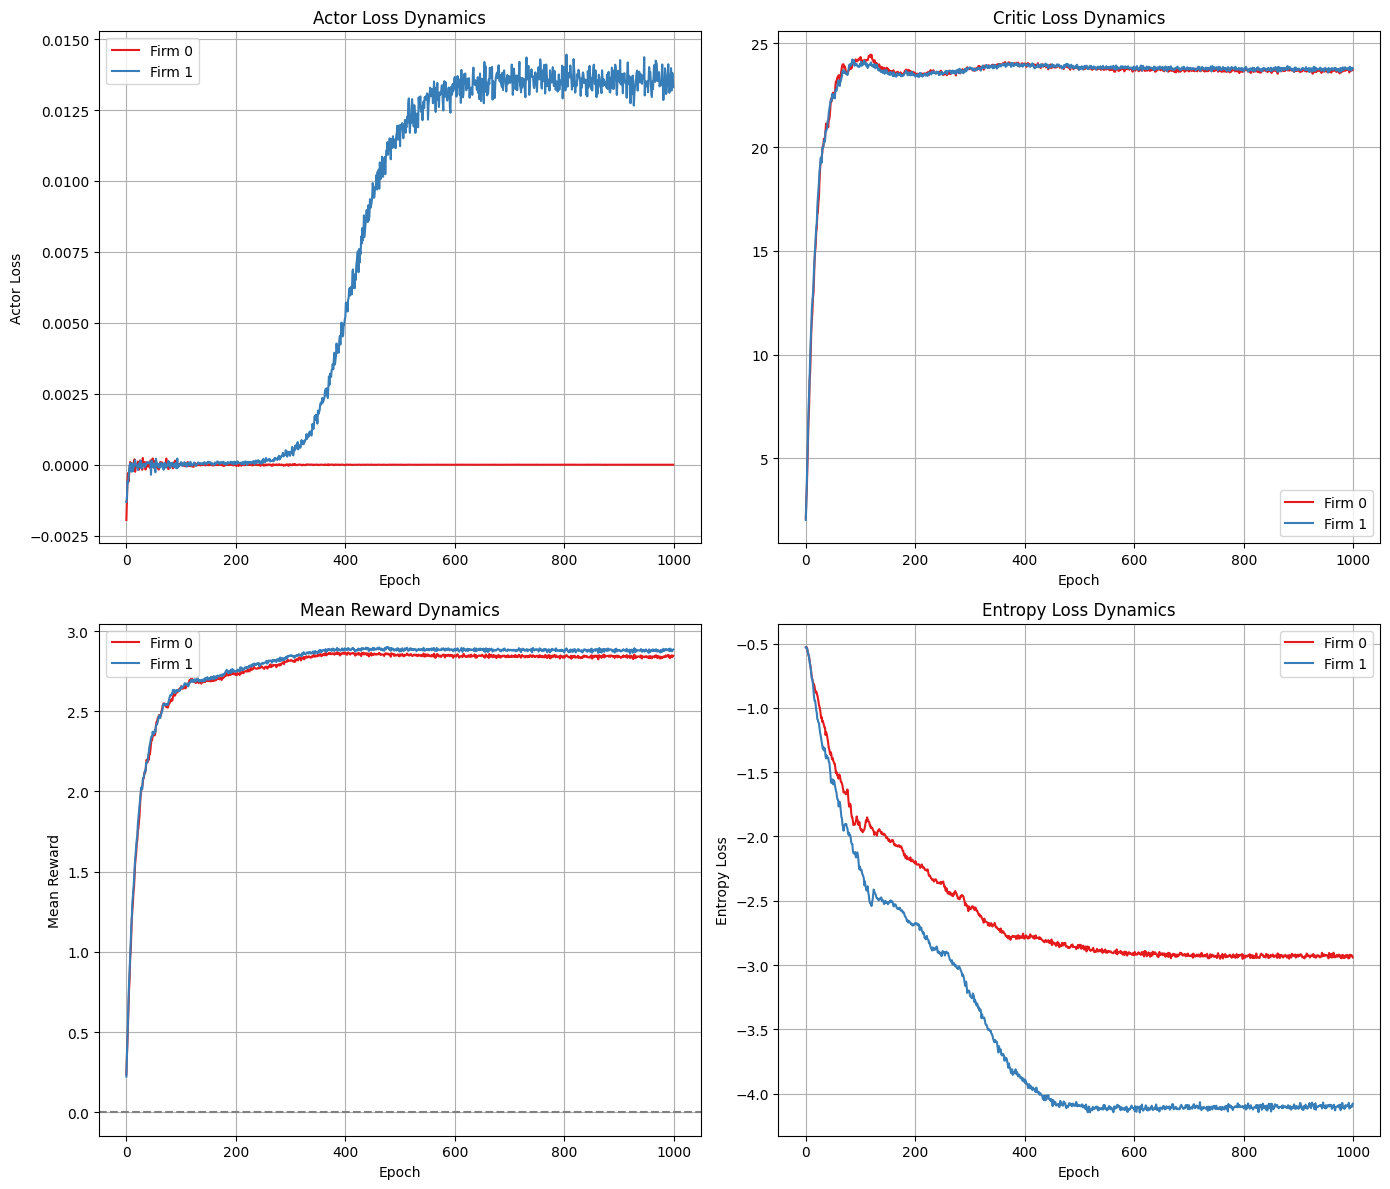

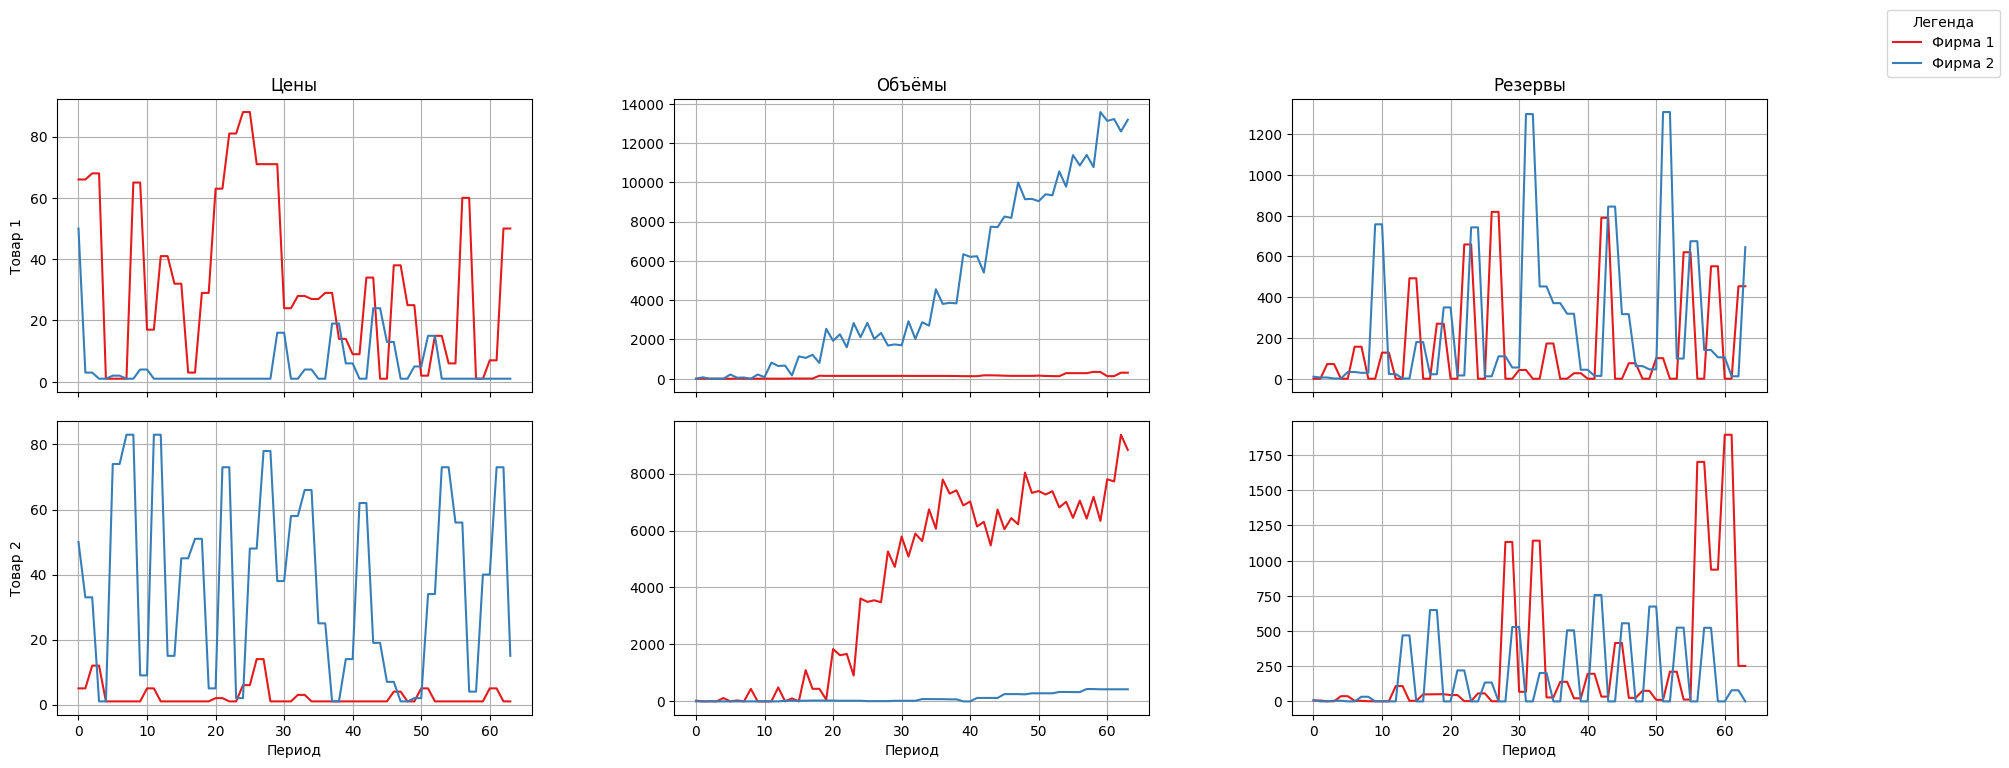

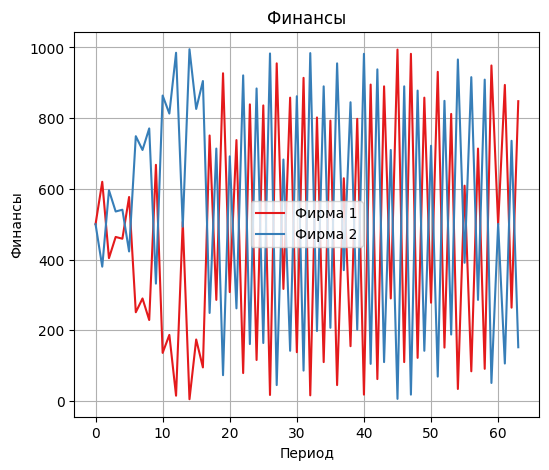

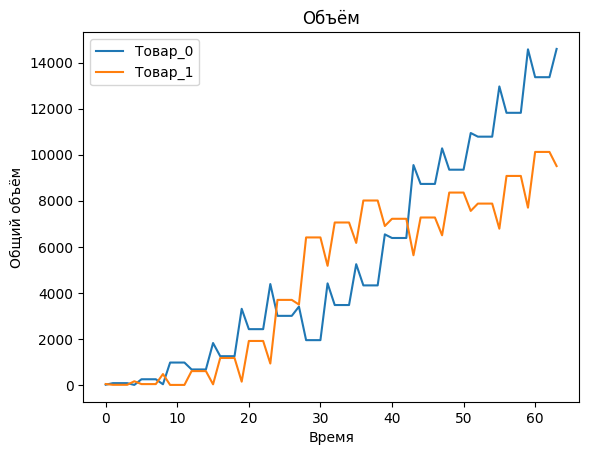

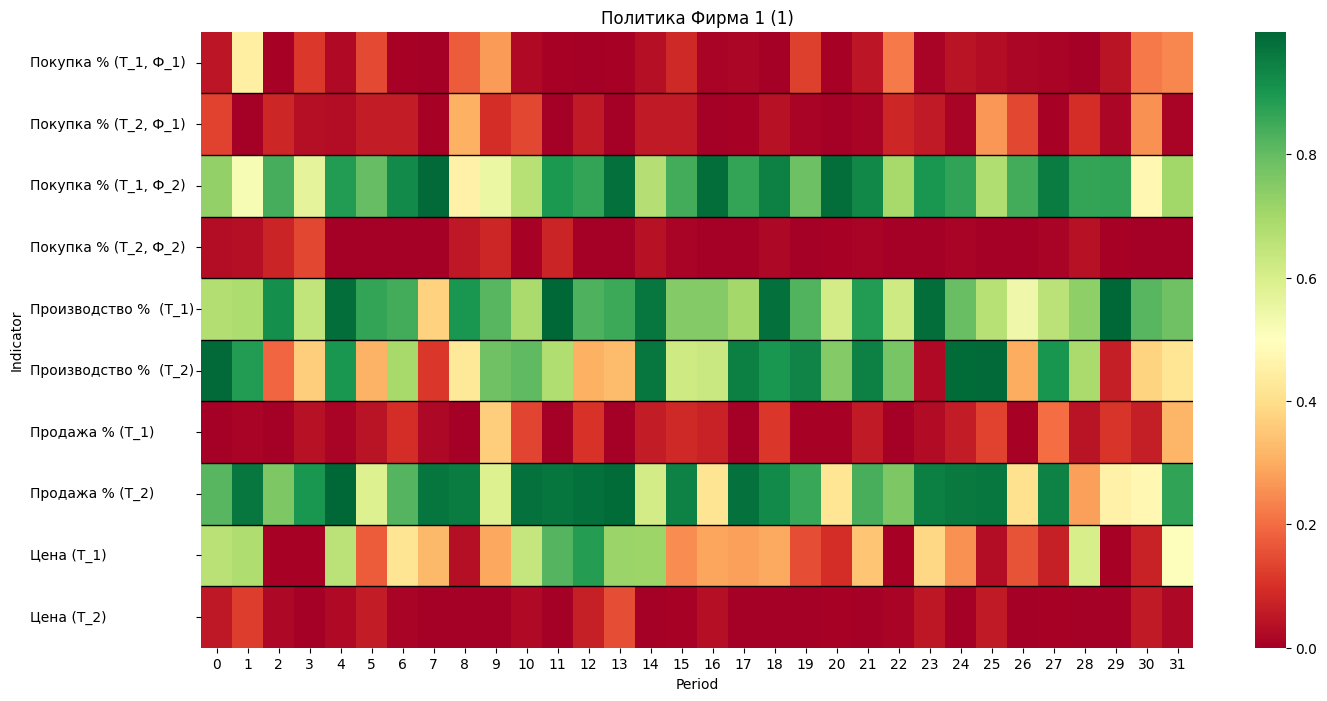

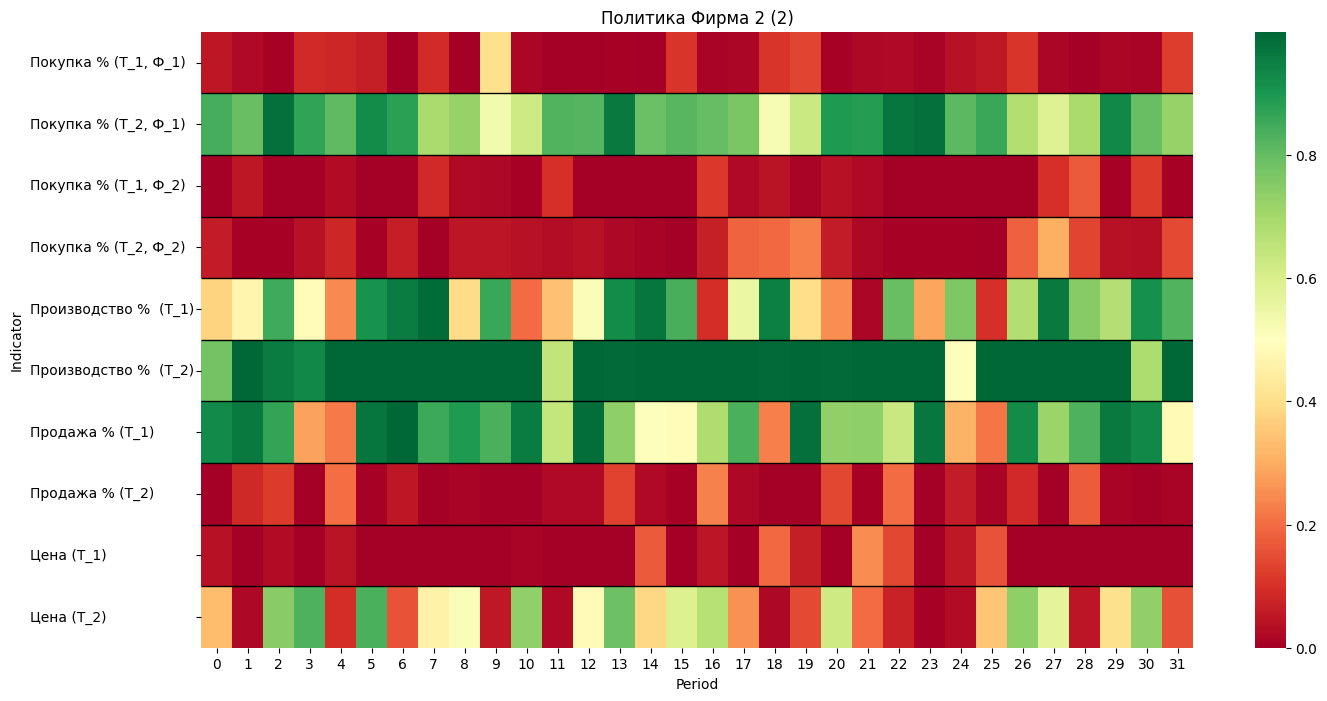

In [6]:
trainer.train(1000, episode_length=32, debug_period=50)
env.change_batch_size(1)
env.reset()
n_periods = 64
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)
plot_environment(env.state_history)
plot_volumes(env.state_history)
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')

# Второй эксперимент


In [10]:

env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork,
                         prod_functions,
                         invest_functions=invest_functions,
                         target='production',
                         production_reg=0,
                         device=device,
                         batch_size=512)
trainer = TrainerPPO(env,
                     learning_rates=(3e-3, 3e-4),
                     batch_size=512,
                     entropy_reg=0.01,
                     buffer_size=8192 * 64,
                     device=device,
                     entropy_gamma=0.999,
                     lr_gamma=0.991,
                     common_optimizer=True
                     )

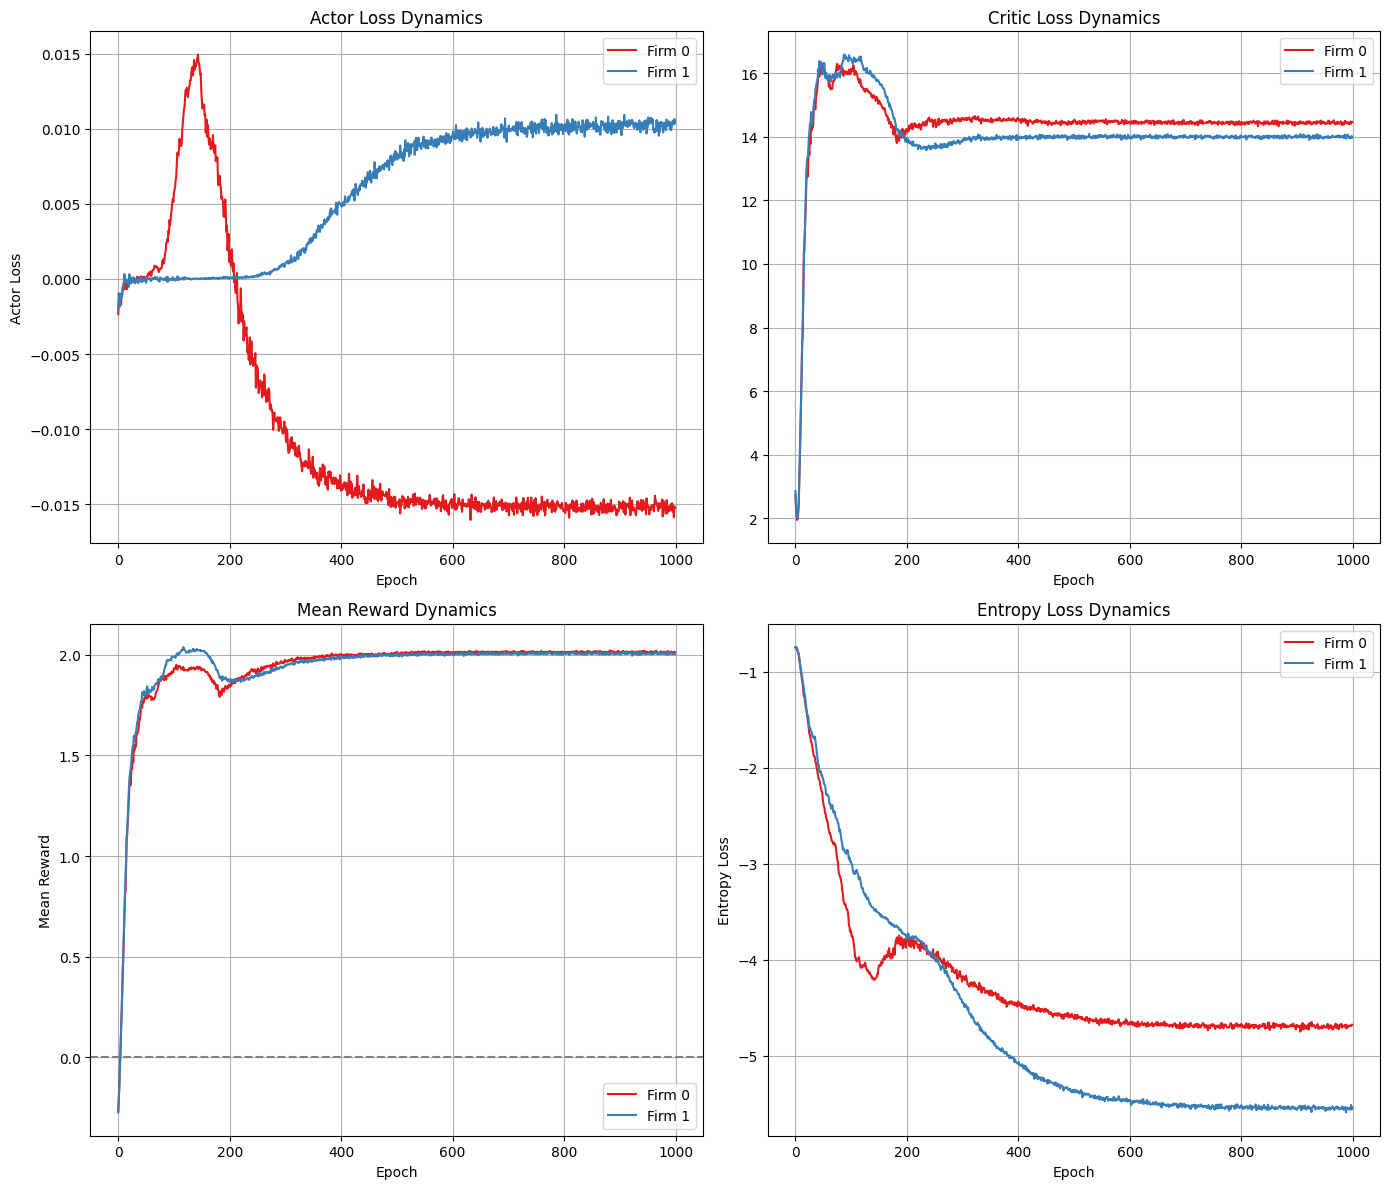

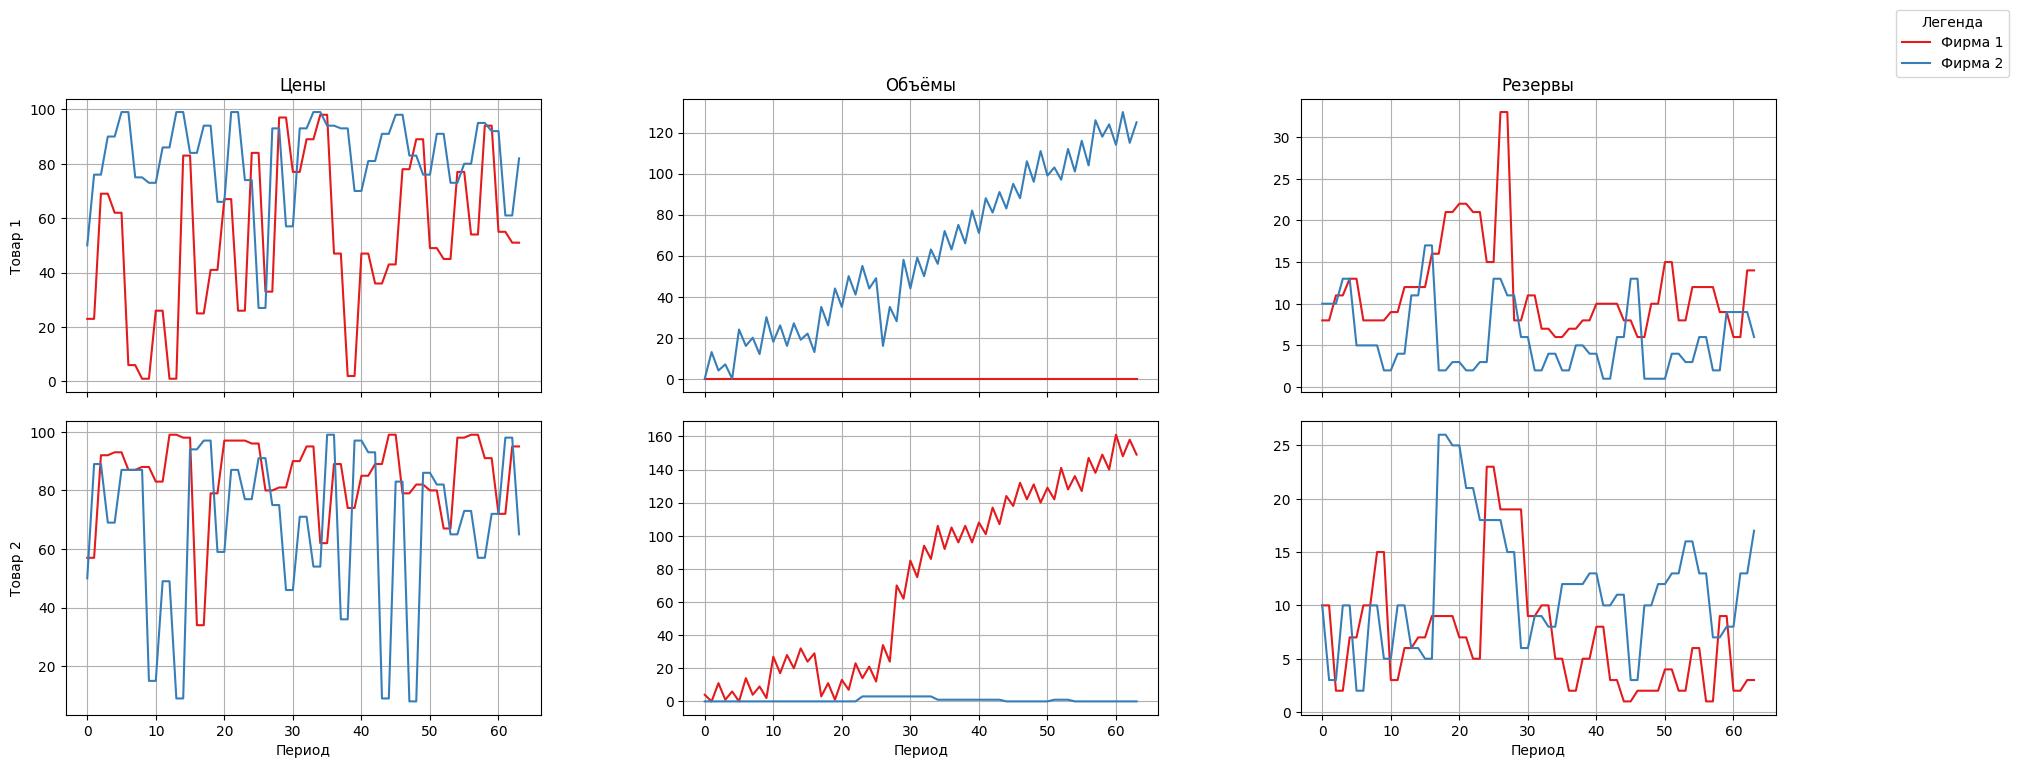

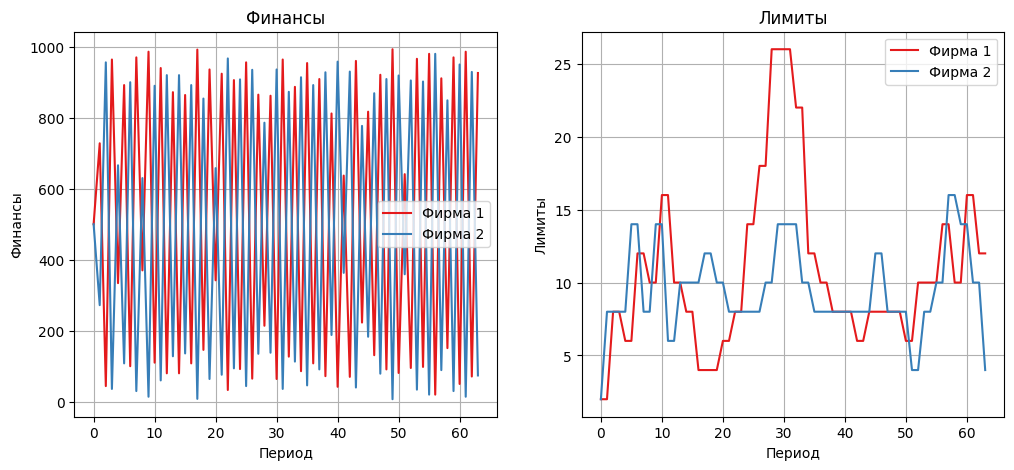

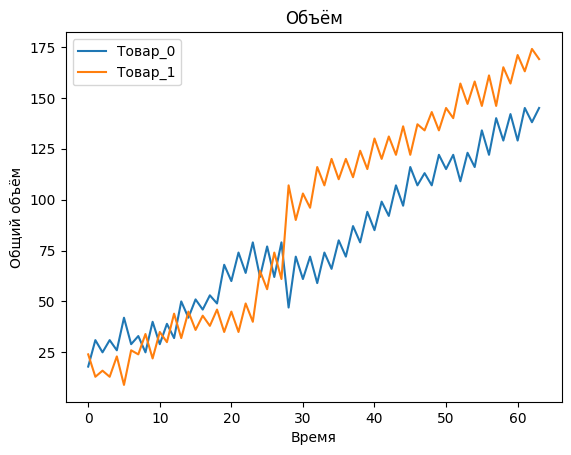

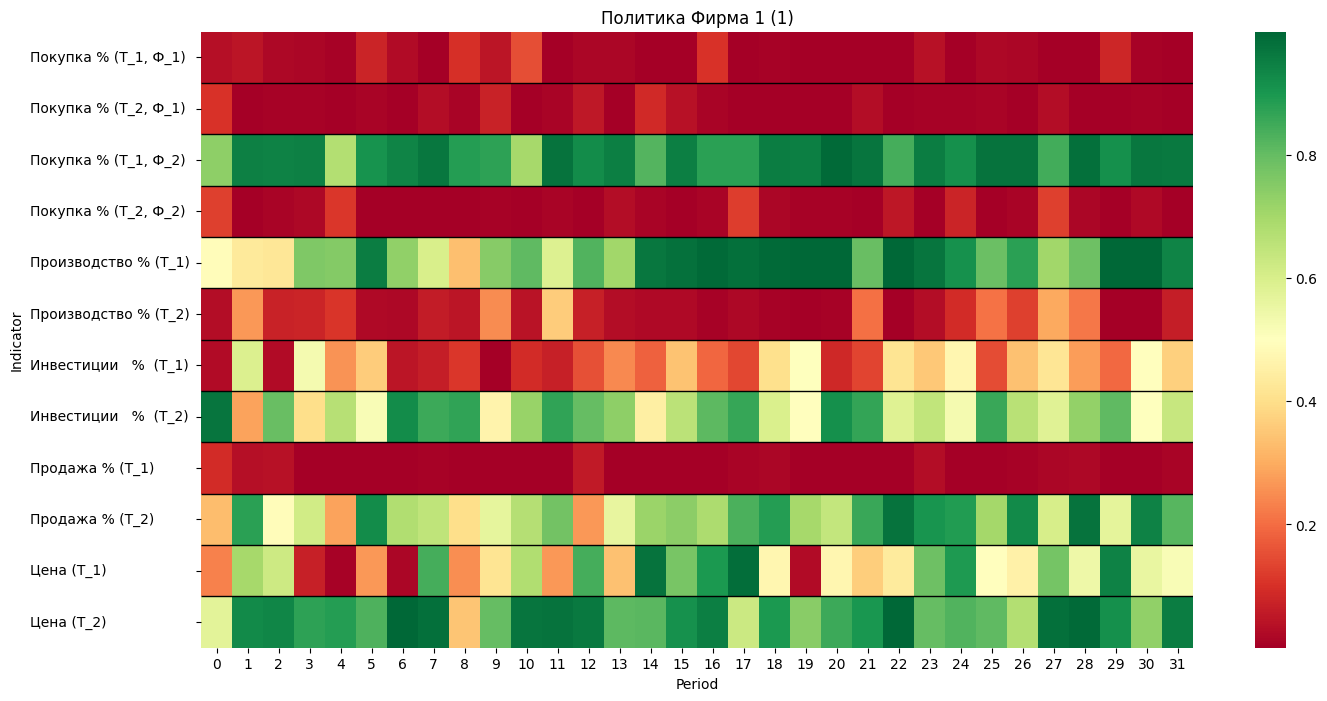

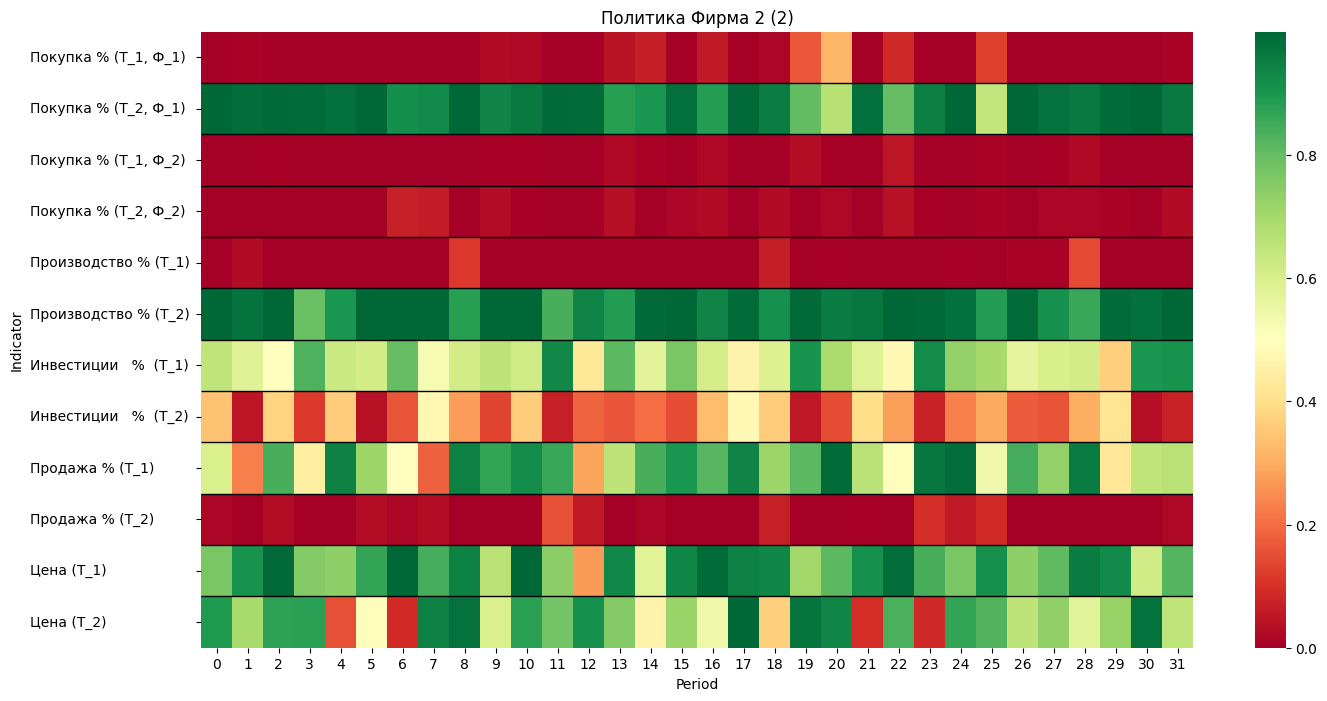

In [11]:
trainer.train(1000, episode_length=32, debug_period=50)
env.change_batch_size(1)
env.reset()
n_periods = 64
for i in range(n_periods):
    env.step_and_record(i % env.market.n_firms)
plot_environment(env.state_history)
plot_volumes(env.state_history)
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')